In [1]:
%autosave 60

Autosaving every 60 seconds


# Установка зависимостей и импорт библиотек

In [ ]:
!pip install -U -q kaggle catppuccin
!mkdir -p ~/.kaggle
!echo '{"username":"dotyushka666","key":"unk"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c teta-ml-2-2025
!unzip /kaggle/working/teta-ml-2-2025.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 4.3 MB/s eta 0:00:00a 0:00:01
Archive:  /kaggle/working/teta-ml-2-2025.zip
  inflating: sample_submition.csv    
  inflating: solution.csv            
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import catppuccin
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")

In [331]:
mpl.style.use(catppuccin.PALETTE.macchiato.identifier)

In [332]:
RANDOM_STATE = 42

# Основная часть
## Обучение стекинга

In [333]:
df_house_train = pd.read_csv("train.csv")
df_house_test = pd.read_csv("test.csv")

In [ ]:
class CategoricalPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features=None, encoding_strategy="auto"):
        self._mean_values = None
        self.cat_features = cat_features
        self.encoding_strategy = encoding_strategy
        self.encoder = None
        self.fitted = False

    def fit(self, X: pd.DataFrame, y: pd.DataFrame = None):
        if self.cat_features is None:
            return self

        if isinstance(X, pd.DataFrame):
            self.mean_values_ = X.select_dtypes(include=[np.number]).mean()
            cat_cols = [col for col in X.columns if X[col].dtype == "object"]
            if not cat_cols:
                return self

        if self.encoding_strategy == "auto":
            unique_counts = X[self.cat_features].nunique()
            if (unique_counts <= 10).all():
                self.encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
            else:
                self.encoder = OrdinalEncoder(
                    handle_unknown="use_encoded_value",
                    unknown_value=-1,
                    encoded_missing_value=-1,
                )
        elif self.encoding_strategy == "onehot":
            self.encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
        else:
            self.encoder = OrdinalEncoder(
                handle_unknown="use_encoded_value",
                unknown_value=-1,
                encoded_missing_value=-1,
            )

        self.encoder.fit(X[self.cat_features])
        self.fitted = True
        return self

    def transform(self, X: pd.DataFrame, catboost: bool = False):
        if not self.fitted or self.cat_features is None:
            return X

        X_transformed = X.copy()

        for col in X_transformed.select_dtypes(include=[np.number]).columns:
            X_transformed[col] = X_transformed[col].fillna(self.mean_values_[col])
        for col in X_transformed.select_dtypes(include=["object"]).columns:
            X_transformed[col] = X_transformed[col].fillna("")

        if catboost:
            return X_transformed

        encoded = self.encoder.transform(X[self.cat_features])

        if isinstance(self.encoder, OneHotEncoder):
            new_cols = self.encoder.get_feature_names_out(self.cat_features)
            X_transformed = pd.concat(
                [
                    X_transformed.drop(columns=self.cat_features),
                    pd.DataFrame(encoded, columns=new_cols, index=X_transformed.index),
                ],
                axis=1,
            )
        else:
            for i, col in enumerate(self.cat_features):
                X_transformed[col] = encoded[:, i]

        return X_transformed

In [ ]:
class UncertaintyEstimator:
    @staticmethod
    def calculate_aleatoric_uncertainty(y_true, y_pred):
        n = len(y_true)
        residuals = y_true - y_pred
        aleatoric_uncertainty = np.sum(residuals**2) / n

        return aleatoric_uncertainty

    @staticmethod
    def calculate_epistemic_uncertainty(y_pred_ensemble):
        mean_prediction = np.mean(y_pred_ensemble, axis=0)
        m = y_pred_ensemble.shape[0]

        squared_diffs = np.sum((y_pred_ensemble - mean_prediction) ** 2, axis=0)
        epistemic_uncertainty = squared_diffs / m

        return epistemic_uncertainty

    def calculate_uncertainty(
        self,
        y_true: np.typing.NDArray,
        y_pred_ensemble: pd.DataFrame | np.typing.NDArray,
    ):
        epistemic = np.mean(
            self.calculate_epistemic_uncertainty(y_pred_ensemble)
        ).round(2)
        aleatoric = np.mean(
            [
                self.calculate_aleatoric_uncertainty(y_true, y_pred)
                for y_pred in y_pred_ensemble
            ]
        ).round(2)
        total = epistemic + aleatoric

        return pd.DataFrame(
            data={
                "uncertaincy": ["epistemic", "aleatoric", "total"],
                "score": [epistemic, aleatoric, total],
            }
        )

    def plot_uncertainty(
        self, y_true: np.typing.NDArray, y_pred_ensemble: pd.DataFrame
    ):
        plt.figure(figsize=(12, 6))

        for col_y_pred in y_pred_ensemble.columns:
            sns.kdeplot(
                (y_true - y_pred_ensemble[col_y_pred]).replace(
                    [np.inf, -np.inf], np.nan
                ),
                label=col_y_pred,
            )

        plt.title("Распределение ошибок предсказаний", fontsize=14, pad=20)
        plt.xlabel("Разность между истинным и предсказанным значением", fontsize=12)
        plt.ylabel("Плотность вероятности", fontsize=12)

        plt.legend(title="Модели", title_fontsize=12, fontsize=10, framealpha=0.9)
        plt.grid()
        plt.tight_layout()
        plt.show()

In [ ]:
class StackingRegressor:
    def __init__(
        self,
        base_models,
        meta_model,
        n_folds=5,
        random_state=42,
        cat_features=None,
        preprocessing=True,
    ):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        self.random_state = random_state
        self.cat_features = cat_features
        self.preprocessing = preprocessing
        self.final_models = {}
        self.meta_model_trained = None
        self.oof_predictions = None

    def _preprocess_data(self, X, y=None, fitting=False, **kwargs):
        """Обработка категориальных признаков"""
        if not self.preprocessing:
            return X

        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)

        if fitting:
            self.preprocessor = CategoricalPreprocessor(
                cat_features=self.cat_features, encoding_strategy="auto"
            )
            self.preprocessor.fit(X)

        return self.preprocessor.transform(X, **kwargs)

    def _create_stratified_folds(self, y, n_bins=5):
        """Создает стратифицированные фолды для регрессии"""
        bins = np.linspace(np.min(y), np.max(y), n_bins + 1)
        return np.digitize(y, bins)

    @staticmethod
    def _post_processing_predict(predict):
        """Пост процессинг для предсказаний модели"""
        return np.round(predict).clip(0, 365)

    def fit(self, X, y):
        """
        Обучение стекинг-модели

        Параметры:
        X: array-like - признаки
        y: array-like - целевая переменная
        """
        X = X.reset_index(drop=True)

        # Создаем страты для StratifiedKFold
        y_binned = self._create_stratified_folds(y)
        skf = StratifiedKFold(
            n_splits=self.n_folds, shuffle=True, random_state=self.random_state
        )

        n_samples = X.shape[0]
        n_models = len(self.base_models)
        self.oof_predictions = np.zeros((n_samples, n_models))

        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_binned)):
            X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_tr = y.iloc[train_idx]

            X_tr_preprocesing = self._preprocess_data(X_tr, fitting=True)
            X_val_preprocesing = self._preprocess_data(X_val, fitting=False)

            for i, (name, model) in tqdm(
                enumerate(self.base_models.items()),
                desc=f"Training {fold} fold",
                total=len(self.base_models),
            ):
                print(f"Train model: {model}")

                if isinstance(model, CatBoostRegressor):
                    model.fit(
                        self._preprocess_data(X_tr, fitting=False, catboost=True), y_tr
                    )

                    self.oof_predictions[val_idx, i] = model.predict(
                        self._preprocess_data(X_val, fitting=False, catboost=True)
                    )
                else:
                    model.fit(X_tr_preprocesing, y_tr)

                    self.oof_predictions[val_idx, i] = model.predict(X_val_preprocesing)

        self.meta_model_trained = self.meta_model
        self.meta_model_trained.fit(self.oof_predictions, y)

        X_preprocessing = self._preprocess_data(X, fitting=True)

        for name, model in tqdm(self.base_models.items(), desc="Traning full data"):
            self.final_models[name] = model
            if isinstance(self.final_models[name], CatBoostRegressor):
                self.final_models[name].fit(
                    self._preprocess_data(X, fitting=False, catboost=True), y
                )
            else:
                self.final_models[name].fit(X_preprocessing, y)

    def predict(self, X, return_base_predictions=False):
        """
        Предсказание для новых данных

        Параметры:
        X: array-like - признаки для предсказания
        return_base_predictions: bool - возвращать ли предсказания базовых моделей

        Возвращает:
        final_predictions: array - финальные предсказания
        (optional) base_predictions: array - предсказания базовых моделей
        """
        X_preprocessing = self._preprocess_data(X, fitting=False)

        base_predictions = np.zeros((X.shape[0], len(self.final_models)))

        for i, (name, model) in enumerate(self.final_models.items()):
            if isinstance(model, CatBoostRegressor):
                base_predictions[:, i] = model.predict(
                    self._preprocess_data(X, fitting=False, catboost=True)
                )
            else:
                base_predictions[:, i] = model.predict(X_preprocessing)

            base_predictions[:, i] = base_predictions[:, i]

        final_predictions = self._post_processing_predict(
            self.meta_model_trained.predict(base_predictions)
        )

        if return_base_predictions:
            return final_predictions, base_predictions
        return final_predictions

    def evaluate_performance(self, X_test, y_test):
        """
        Оценка производительности моделей на тестовом наборе
        Возвращает DataFrame с метриками и временем предсказания
        """
        from time import time

        if not self.final_models or not self.meta_model_trained:
            raise ValueError("Сначала выполните fit()")

        final_time = 0
        results = {}

        # Предсказания базовых моделей
        base_preds = np.zeros((X_test.shape[0], len(self.final_models)))

        for i, (name, model) in enumerate(self.final_models.items()):
            start_time = time()

            if isinstance(model, CatBoostRegressor):
                preds = model.predict(
                    self._preprocess_data(X_test, fitting=False, catboost=True)
                )
            else:
                preds = model.predict(self._preprocess_data(X_test, fitting=False))

            pred_time = time() - start_time
            final_time += pred_time

            preds_preprocess = self._post_processing_predict(preds)
            mse = mean_squared_error(y_test, preds_preprocess)
            results[name] = {
                "MSE": mse,
                "prediction_time": pred_time,
                "predictions": preds_preprocess,
            }
            base_preds[:, i] = preds

        start_time = time()
        final_preds = self.meta_model_trained.predict(base_preds)
        final_preds = self._post_processing_predict(final_preds)
        pred_time = time() - start_time

        results["Stacking"] = {
            "MSE": mean_squared_error(y_test, final_preds),
            "prediction_time": pred_time + final_time,
            "predictions": final_preds,
        }

        self.performance_metrics = pd.DataFrame.from_dict(results, orient="index")
        self.performance_metrics["model"] = self.performance_metrics.index
        self.performance_metrics = self.performance_metrics.reset_index(drop=True)

        return self.performance_metrics

    def plot_performance(self):
        """Визуализация производительности моделей"""
        if self.performance_metrics is None:
            raise ValueError("Сначала выполните evaluate_performance()")

        metrics = self.performance_metrics.sort_values("MSE").copy(deep=True)

        plt.figure(figsize=(14, 6))

        # 1. График MSE
        plt.subplot(1, 2, 1)
        ax1 = sns.barplot(data=metrics, x="MSE", y="model")

        for p in ax1.patches:
            ax1.annotate(
                f"{p.get_width():.2f}",
                (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                ha="left",
                va="center",
                xytext=(5, 0),
                textcoords="offset points",
            )

        ax1.set_xlim(0, metrics["MSE"].max() * 1.25)
        ax1.set_title("Сравнение MSE моделей", pad=20)
        ax1.set_xlabel("Mean Squared Error")
        ax1.set_ylabel("Модель")
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")
        ax1.grid(False)

        # 2. График времени предсказания
        plt.subplot(1, 2, 2)
        ax2 = sns.barplot(data=metrics, x="model", y="prediction_time")

        for p in ax2.patches:
            ax2.annotate(
                f"{p.get_height():.2f} сек",
                (p.get_x() + p.get_width() / 2.0, p.get_height()),
                ha="center",
                va="center",
                xytext=(0, 10),
                textcoords="offset points",
            )

        ax2.set_ylim(0, metrics["prediction_time"].max() * 1.15)
        ax2.set_title("Время предсказания моделей", pad=20)
        ax2.set_xlabel("Модель")
        ax2.set_ylabel("Время (секунды)")
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
        ax2.grid(False)

        plt.tight_layout()
        plt.show()

### Подготовка данных

Для подготовки данных удаляем признаки, которые не будут использоваться для обучения модели.  
Обработка самих признаков будет производиться в пайплайне. В качестве обработки для категориальных признаков будет использоваться OrdinalEncoder для быстроты обучения моделей.

In [337]:
del_features = ["name", "_id", "last_dt"]

cat_features = ["host_name", "location_cluster", "location", "type_house"]

In [340]:
df_house_train_clear = df_house_train.drop(columns=del_features)

df_house_train_clear.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,host_name,location_cluster,location,lat,lon,type_house,sum,min_days,amt_reviews,avg_reviews,total_host,target
0,Sarina,Queens,Neponsit,40.57215,-73.85822,Entire home/apt,350,2,5,2.88,1,334
1,Howard T.,Brooklyn,Clinton Hill,40.69172,-73.96934,Shared room,40,5,8,0.13,1,0
2,Julie,Manhattan,Upper West Side,40.77673,-73.98011,Entire home/apt,200,5,0,NaN,1,0
3,Federico,Manhattan,Harlem,40.81530,-73.95080,Private room,65,2,18,0.64,1,0
4,Lisa,Brooklyn,Bushwick,40.70230,-73.92935,Private room,99,2,26,0.76,1,155


In [342]:
df_house_test_clear = df_house_test.drop(columns=del_features)
y_true = pd.read_csv("solution.csv")["prediction"]

df_house_test_clear.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,host_name,location_cluster,location,lat,lon,type_house,sum,min_days,amt_reviews,avg_reviews,total_host
0,Lou,Brooklyn,Sunset Park,40.66468,-73.99785,Entire home/apt,399,1,0,NaN,5
1,Nelly,Brooklyn,Bedford-Stuyvesant,40.67880,-73.92722,Private room,43,1,4,2.00,3
2,Kara,Manhattan,Hell's Kitchen,40.76170,-73.99762,Entire home/apt,275,30,2,0.08,121
3,Jonathan,Brooklyn,Williamsburg,40.70748,-73.92835,Private room,40,3,0,NaN,2
4,Celeste,Brooklyn,Crown Heights,40.67249,-73.95564,Private room,55,4,1,0.14,1


### Обучение

Ниже взяты базовые модели для обучения стекинга. В качестве мета-модели взята линейная регрессия.  

- *OOF* предсказания сохраняются в объекте класса для дальнейшего анализа.
- Предсказания *OOF* не обрабатываются после предсказания.
- Предсказания базовых моделей, когда обучаются на всем датасете, обрабатываются как и для мета-модели.
- *Пост-обработка* заключается в округлении до целого числа и обрезка от 0 до 365.

In [ ]:
base_models = {
    "RandomForest": RandomForestRegressor(random_state=RANDOM_STATE),
    "XGBoost": XGBRegressor(random_state=RANDOM_STATE, enable_categorical=False),
    "LightGBM": LGBMRegressor(random_state=RANDOM_STATE),
    "LinearRegression": LinearRegression(positive=True),
    "CatBoost": CatBoostRegressor(
        random_state=RANDOM_STATE,
        verbose=0,
        cat_features=cat_features,
        loss_function="RMSE",
    ),
}

meta_model = LinearRegression()

In [ ]:
stacker = StackingRegressor(
    base_models=base_models,
    meta_model=meta_model,
    cat_features=cat_features,
    preprocessing=True,
    random_state=RANDOM_STATE,
)

In [341]:
stacker.fit(df_house_train_clear.drop(columns="target"), df_house_train_clear["target"])

Training 0 fold:   0%|          | 0/5 [00:00<?, ?it/s]

Train model: RandomForestRegressor(random_state=42)


Training 0 fold:  20%|██        | 1/5 [00:23<01:33, 23.26s/it]

Train model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)


Training 0 fold:  40%|████      | 2/5 [00:23<00:29,  9.76s/it]

Train model: LGBMRegressor(random_state=42)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 29336, number of used features: 11
[LightGBM] [Info] Start training from score 112.814017


Training 0 fold:  60%|██████    | 3/5 [00:23<00:10,  5.44s/it]

Train model: LinearRegression(positive=True)
Train model: <catboost.core.CatBoostRegressor object at 0x7fda83428d00>


Training 1 fold:   0%|          | 0/5 [00:00<?, ?it/s]

Train model: RandomForestRegressor(random_state=42)


Training 1 fold:  20%|██        | 1/5 [00:22<01:31, 22.98s/it]

Train model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)


Training 1 fold:  40%|████      | 2/5 [00:23<00:28,  9.63s/it]

Train model: LGBMRegressor(random_state=42)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1845
[LightGBM] [Info] Number of data points in the train set: 29337, number of used features: 11
[LightGBM] [Info] Start training from score 112.795821


Training 1 fold:  60%|██████    | 3/5 [00:23<00:10,  5.35s/it]

Train model: LinearRegression(positive=True)
Train model: <catboost.core.CatBoostRegressor object at 0x7fda83428d00>


Training 2 fold:   0%|          | 0/5 [00:00<?, ?it/s]

Train model: RandomForestRegressor(random_state=42)


Training 2 fold:  20%|██        | 1/5 [00:22<01:31, 22.87s/it]

Train model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)


Training 2 fold:  40%|████      | 2/5 [00:23<00:29,  9.83s/it]

Train model: LGBMRegressor(random_state=42)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1845
[LightGBM] [Info] Number of data points in the train set: 29337, number of used features: 11
[LightGBM] [Info] Start training from score 112.819545


Training 2 fold:  60%|██████    | 3/5 [00:23<00:10,  5.47s/it]

Train model: LinearRegression(positive=True)
Train model: <catboost.core.CatBoostRegressor object at 0x7fda83428d00>


Training 3 fold:   0%|          | 0/5 [00:00<?, ?it/s]

Train model: RandomForestRegressor(random_state=42)


Training 3 fold:  20%|██        | 1/5 [00:22<01:31, 22.91s/it]

Train model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)


Training 3 fold:  40%|████      | 2/5 [00:23<00:28,  9.60s/it]

Train model: LGBMRegressor(random_state=42)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 29337, number of used features: 11
[LightGBM] [Info] Start training from score 112.669087


Training 3 fold:  60%|██████    | 3/5 [00:23<00:10,  5.34s/it]

Train model: LinearRegression(positive=True)
Train model: <catboost.core.CatBoostRegressor object at 0x7fda83428d00>


Training 4 fold:   0%|          | 0/5 [00:00<?, ?it/s]

Train model: RandomForestRegressor(random_state=42)


Training 4 fold:  20%|██        | 1/5 [00:22<01:31, 22.81s/it]

Train model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)


Training 4 fold:  40%|████      | 2/5 [00:23<00:28,  9.56s/it]

Train model: LGBMRegressor(random_state=42)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 29337, number of used features: 11
[LightGBM] [Info] Start training from score 112.734670


Training 4 fold:  60%|██████    | 3/5 [00:23<00:10,  5.32s/it]

Train model: LinearRegression(positive=True)
Train model: <catboost.core.CatBoostRegressor object at 0x7fda83428d00>


Traning full data:  40%|████      | 2/5 [00:29<00:37, 12.49s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1855
[LightGBM] [Info] Number of data points in the train set: 36671, number of used features: 11
[LightGBM] [Info] Start training from score 112.766628


Traning full data: 100%|██████████| 5/5 [00:50<00:00, 10.01s/it]


In [343]:
results_performance_models = stacker.evaluate_performance(df_house_test_clear, y_true)

<ipython-input-336-33273e467038>:198: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


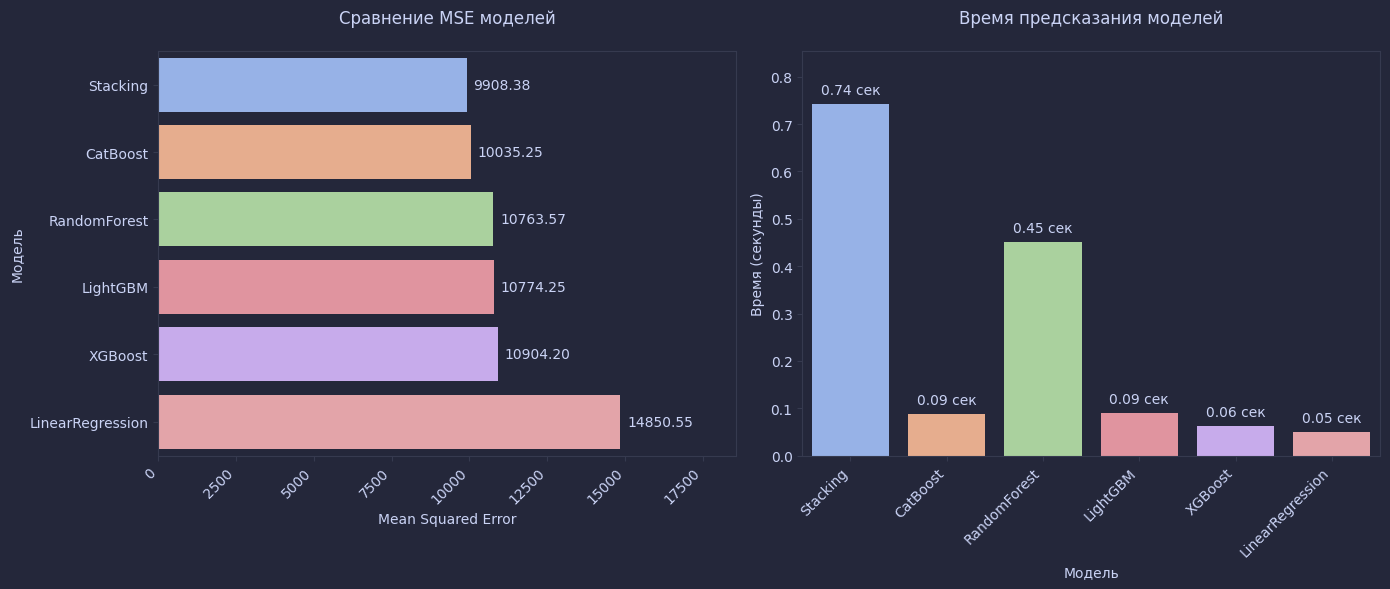

In [344]:
stacker.plot_performance()

### **Выводы**:
- Обучение стекинга дает прирост по метрике на тестовой выборке. (*MSE* уменьшилось приблизительно на 100 пунктов от лучшей базовой модели).
- Лучше всех по *MSE* на тестовой выборке это *CatBoost*. Остальные ансамбли (*Random Forest*, *LightGBM*, *XGBoost*) выдают результаты значительно хуже чем *CatBoost*.
- Дольше всех предсказывает *Random Forest* из базовых моделей.
- Стекинг работает медленнее всех из-за последовательного выполнения, при этом основное "бутылочное горлышко" связано именно с *Random Forest*. Ускорить можно при параллелизации предсказаний.

## Оценка неопределенности

In [345]:
uncertainty_est = UncertaintyEstimator()

### Оценка неопределенности базовых моделей на OOF предсказаниях

Оценим неопределенность базовых моделей на сохраненных предсказаниях для обучения мета-модели (OOF).

In [346]:
# Собираем сохраненные предикты базовых моделей при обучении oof
oof_predict_models = pd.DataFrame(
    stacker.oof_predictions, columns=stacker.base_models.keys()
)

oof_predict_models.head()

,RandomForest,XGBoost,LightGBM,LinearRegression,CatBoost
0,195.26,269.014435,235.569763,149.957603,225.201473
1,115.08,2.215861,20.486193,91.675694,101.101887
2,13.78,23.778084,25.507366,85.600422,23.190975
3,94.50,47.914688,64.024118,99.020065,56.499146
4,73.66,94.346001,103.692204,105.301792,111.780097


In [347]:
uncertainty_est.calculate_uncertainty(
    df_house_train_clear["target"].values, oof_predict_models.T.values
)

,uncertaincy,score
0,epistemic,1087.80
1,aleatoric,11518.28
2,total,12606.08


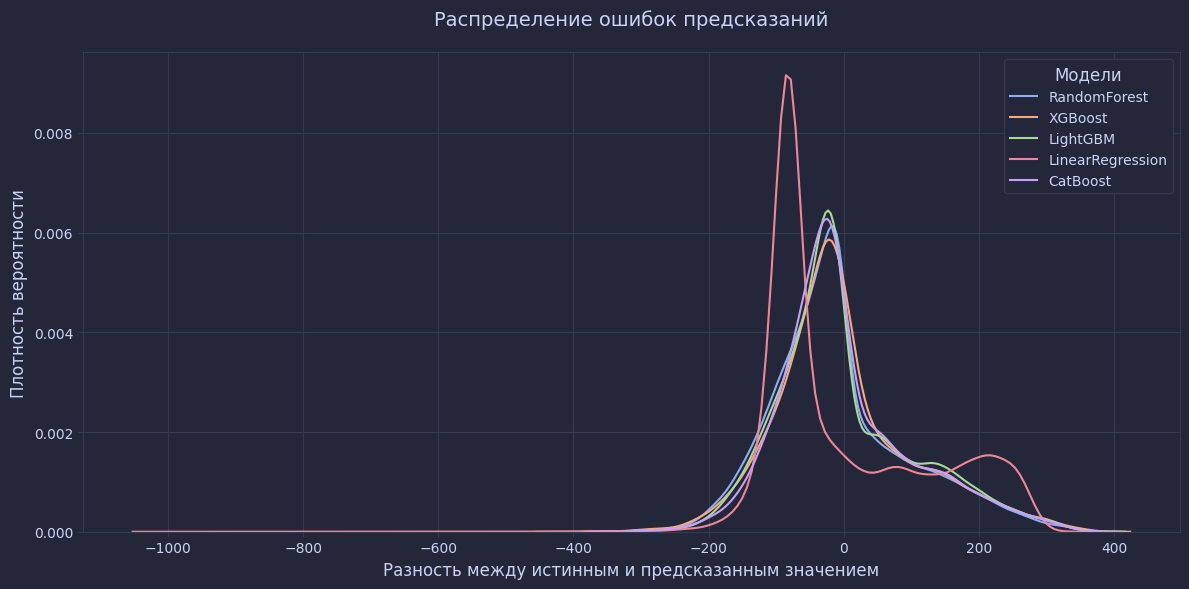

In [348]:
uncertainty_est.plot_uncertainty(
    df_house_train_clear["target"].values, oof_predict_models
)

#### **Выводы**:
- *Алеаторная* (неопределенность данных) неопределенность **сильно выше**, чем *эпистемическая* (неопределенность знаний) $\rightarrow$ **Высокая** случайность в данных (скорей всего есть шумные данные или неучтенные факторы).
- *Эпистемическая* неопределенность сравнительно **низкая** $\rightarrow$ Модели достаточно уверены в своих предсказаниях, т.е. архитектура и обучение моделей стабильны, и неопределенность из-за структуры модели невелика.
- Деревья лучше справляются с текущим типом данных по сравнению с линейной моделью.
- График также подтверждает, что имеется *неопределенность данных*.

### Оценка неопределенности базовых моделей на тестовой выборке

Также оценим неопределенность на тестовой выборке для базовых моделей.

In [349]:
filter_res_performance_models = results_performance_models[
    results_performance_models["model"].isin(stacker.base_models.keys())
]

filter_res_performance_models

,MSE,prediction_time,predictions,model
0,10763.569208,0.451375,"[204.0, 205.0, 343.0, 96.0, 31.0, 31.0, 6.0, 3...",RandomForest
1,10904.195272,0.063655,"[162.0, 194.0, 334.0, 67.0, 26.0, 46.0, 0.0, 3...",XGBoost
2,10774.248855,0.090711,"[236.0, 167.0, 299.0, 63.0, 26.0, 56.0, 8.0, 4...",LightGBM
3,14850.545239,0.049922,"[84.0, 105.0, 207.0, 97.0, 79.0, 90.0, 77.0, 8...",LinearRegression
4,10035.245501,0.087204,"[185.0, 169.0, 309.0, 33.0, 38.0, 29.0, 0.0, 3...",CatBoost


In [350]:
predict_base_models = pd.DataFrame(
    np.vstack(filter_res_performance_models["predictions"].values).T,
    columns=filter_res_performance_models["model"].values.tolist(),
)

predict_base_models.head()

,RandomForest,XGBoost,LightGBM,LinearRegression,CatBoost
0,204.0,162.0,236.0,84.0,185.0
1,205.0,194.0,167.0,105.0,169.0
2,343.0,334.0,299.0,207.0,309.0
3,96.0,67.0,63.0,97.0,33.0
4,31.0,26.0,26.0,79.0,38.0


In [351]:
uncertainty_est.calculate_uncertainty(y_true, predict_base_models.T.values)

,uncertaincy,score
0,epistemic,1043.34
1,aleatoric,11465.56
2,total,12508.90


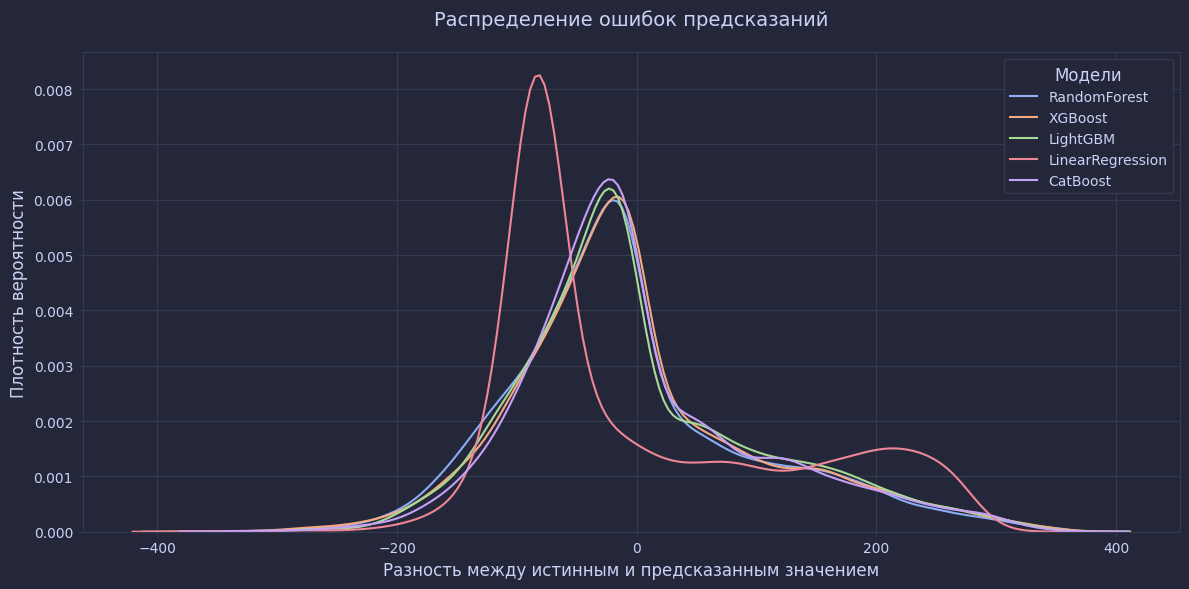

In [352]:
uncertainty_est.plot_uncertainty(y_true, predict_base_models)

#### **Выводы**:
- Выводы выше также подтвердились и на тестовой выборке.